In [1]:
%matplotlib inline


# Label Propagation digits active learning

Demonstrates an active learning technique to learn handwritten digits
using label propagation.

We start by training a label propagation model with only 10 labeled points,
then we select the top five most uncertain points to label. Next, we train
with 15 labeled points (original 10 + 5 new ones). We repeat this process
four times to have a model trained with 30 labeled examples. Note you can
increase this to label more than 30 by changing `max_iterations`. Labeling
more than 30 can be useful to get a sense for the speed of convergence of
this active learning technique.

A plot will appear showing the top 5 most uncertain digits for each iteration
of training. These may or may not contain mistakes, but we will train the next
model with their true labels.



Label Propagation digits active learning

Demonstrates an active learning technique to learn handwritten digits
using label propagation.

We start by training a label propagation model with only 10 labeled points,
then we select the top five most uncertain points to label. Next, we train
with 15 labeled points (original 10 + 5 new ones). We repeat this process
four times to have a model trained with 30 labeled examples. Note you can
increase this to label more than 30 by changing `max_iterations`. Labeling
more than 30 can be useful to get a sense for the speed of convergence of
this active learning technique.

A plot will appear showing the top 5 most uncertain digits for each iteration
of training. These may or may not contain mistakes, but we will train the next
model with their true labels.

Iteration 0 ______________________________________________________________________
Label Spreading model: 40 labeled & 290 unlabeled (330 total)
              precision    recall  f1-score   s

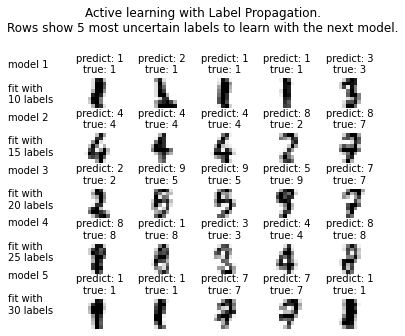

In [12]:
"""
========================================
Label Propagation digits active learning
========================================

Demonstrates an active learning technique to learn handwritten digits
using label propagation.

We start by training a label propagation model with only 10 labeled points,
then we select the top five most uncertain points to label. Next, we train
with 15 labeled points (original 10 + 5 new ones). We repeat this process
four times to have a model trained with 30 labeled examples. Note you can
increase this to label more than 30 by changing `max_iterations`. Labeling
more than 30 can be useful to get a sense for the speed of convergence of
this active learning technique.

A plot will appear showing the top 5 most uncertain digits for each iteration
of training. These may or may not contain mistakes, but we will train the next
model with their true labels.
"""
print(__doc__)

# Authors: Clay Woolam <clay@woolam.org>
# License: BSD

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

from sklearn import datasets
from sklearn.semi_supervised import LabelSpreading
from sklearn.metrics import classification_report, confusion_matrix

digits = datasets.load_digits()
rng = np.random.RandomState(0)
indices = np.arange(len(digits.data))
rng.shuffle(indices)

# X represente les coordonées des pixels représentant le chiffre
# y contient les labels de chaque chiffre
X = digits.data[indices[:330]]
y = digits.target[indices[:330]]
images = digits.images[indices[:330]]

n_total_samples = len(y)
n_labeled_points = 40
max_iterations = 5

unlabeled_indices = np.arange(n_total_samples)[n_labeled_points:]
f = plt.figure()

for i in range(max_iterations):
    #Condition de sortie (si tout est labelisé)
    if len(unlabeled_indices) == 0:
        print("No unlabeled items left to label.")
        break
    #Délabelisation des données que l'on veut non labelisé (pour le sujet semi supervised)
    y_train = np.copy(y)
    y_train[unlabeled_indices] = -1
    #Initialisation du model semi supervised
    lp_model = LabelSpreading(gamma=0.25, max_iter=20)
    lp_model.fit(X, y_train)
 
    #Prédiction de TOUT les unlabeled
    predicted_labels = lp_model.transduction_[unlabeled_indices]
    #VRAI Label
    true_labels = y[unlabeled_indices]

    cm = confusion_matrix(true_labels, predicted_labels,
                          labels=lp_model.classes_)

    print("Iteration %i %s" % (i, 70 * "_"))
    print("Label Spreading model: %d labeled & %d unlabeled (%d total)"
          % (n_labeled_points, n_total_samples - n_labeled_points,
             n_total_samples))

    print(classification_report(true_labels, predicted_labels))

    print("Confusion matrix")
    print(cm)

    # compute the entropies of transduced label distributions
    pred_entropies = stats.distributions.entropy(
        lp_model.label_distributions_.T)

    # select up to 5 digit examples that the classifier is most uncertain about
    uncertainty_index = np.argsort(pred_entropies)[::-1]
    uncertainty_index = uncertainty_index[
        np.in1d(uncertainty_index, unlabeled_indices)][:5]

    # keep track of indices that we get labels for
    delete_indices = np.array([], dtype=int)

    # for more than 5 iterations, visualize the gain only on the first 5
    if i < 5:
        f.text(.05, (1 - (i + 1) * .183),
               "model %d\n\nfit with\n%d labels" %
               ((i + 1), i * 5 + 10), size=10)
    for index, image_index in enumerate(uncertainty_index):
        image = images[image_index]

        # for more than 5 iterations, visualize the gain only on the first 5
        if i < 5:
            sub = f.add_subplot(5, 5, index + 1 + (5 * i))
            sub.imshow(image, cmap=plt.cm.gray_r, interpolation='none')
            sub.set_title("predict: %i\ntrue: %i" % (
                lp_model.transduction_[image_index], y[image_index]), size=10)
            sub.axis('off')

        # labeling 5 points, remote from labeled set
        delete_index, = np.where(unlabeled_indices == image_index)
        delete_indices = np.concatenate((delete_indices, delete_index))

    unlabeled_indices = np.delete(unlabeled_indices, delete_indices)
    n_labeled_points += len(uncertainty_index)

f.suptitle("Active learning with Label Propagation.\nRows show 5 most "
           "uncertain labels to learn with the next model.", y=1.15)
plt.subplots_adjust(left=0.2, bottom=0.03, right=0.9, top=0.9, wspace=0.2,
                    hspace=0.85)
plt.show()
